In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from lorenz63 import solve_l63_rk4
sys.path.append('../')
from esn.utils import errors, scalers
from esn.validation import validate, set_ESN
from esn.esn import ESN

# Generate the data:
Solve the Lorenz 63 system using RK4. The parameters and inital condition are selected to ensure the system is chaotic. 

In [2]:
dim = 3
# Parameters to ensure the system is chaotic
params = [2.667, 28, 10]  # beta, rho, sigma
u0 = np.array([0.0, 1.0, 1.0])  # initial condition

dt = 0.01  # time step
t_lyap = 0.9**(-1)  # Lyapunov time

N_lyap = int(t_lyap/dt)
N_trans = 2000  # initial transient to discard
N_total = 500*N_lyap + N_trans
time_array, U_rk4, derU = solve_l63_rk4(N_total, dt, u0=u0, params=params)
U_rk4 = U_rk4[N_trans:]  # remove the initial transient

Prepare the training, validation and test data. Allow for a washout phase in the reservoir. 

In [3]:
# set sizes
washout_size = 100
train_size = 10000
val_size = 5000
test_washout_size = 100

# Extract the shape of the original data
total_samples, num_features = U_rk4.shape

# Split the data into different datasets
U_washout = U_rk4[:washout_size, :]
U_train_input = U_rk4[washout_size:washout_size + train_size, :]
U_train_label = U_rk4[washout_size + 1: washout_size + train_size + 1, :]
U_val_input = U_rk4[washout_size + train_size: washout_size + train_size + val_size, :]
U_val_label = U_rk4[washout_size + train_size + 1: washout_size + train_size + val_size + 1, :]
U_test_washout = U_rk4[washout_size + train_size + val_size:washout_size + train_size + val_size + test_washout_size, :]
U_test = U_rk4[washout_size + train_size + val_size + test_washout_size:, :]

# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape}")
print(f"U_val shape: {U_val_input.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: (10000, 3)
U_val shape: (5000, 3)
U_test shape: (40301, 3)


# Training and Validation of ESNs

In [8]:
# specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
param_names = ['spectral_radius', 'input_scaling']

# range for hyperparameters 
spec_in = 0.25
spec_end = 1.0
in_scal_in = 0.1
in_scal_end = 10.0
grid_range = [[spec_in, spec_end], [in_scal_in, in_scal_end]]

# how to scale the search for each hyperparameter in the given range, uniform or in log10
param_scales = ['uniform', 'log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])

N_washout = 40 # number of washout steps
N_val = 50  # number of validation steps

# fixed properties of the ESN
ESN_dict = {'reservoir_size': 100,
            'dimension': dim,
            'reservoir_connectivity': 3,
            }
tikhonov = 1e-6

min_dict = validate(
    grid_range=grid_range, 
    param_names=param_names, 
    param_scales=param_scales, 
    n_calls=20, # number of total trials  
    n_initial_points=10, # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict, 
    U_washout_train=U_washout, 
    tikh=tikhonov,
    n_realisations=5, # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label, 
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=2, # number of folds, i.e., validation time series that start from random time instances 
    N_washout_steps=N_washout, 
    N_val_steps=N_val, 
    random_seed=20, # random seed for the bayesian optimization
    error_measure=errors.rmse) # error measure to optimize over

Input to run_gp:([Real(low=0.25, high=1.0, prior='uniform', transform='identity'), Real(low=-1.0, high=1.0, prior='uniform', transform='identity')], 20, 10, 20)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6946334636687639
input_scaling 4.881255012149711


Val regime: 0
Fold: 0 , fold error:  533.4925988365486
Fold: 1 , fold error:  8.683462160164593
Val regime error: 271.0880304983566
Realisation error: 271.0880304983566


Realisation: 1
spectral_radius 0.6946334636687639
input_scaling 4.881255012149711


Val regime: 0
Fold: 0 , fold error:  9.085106991647168
Fold: 1 , fold error:  70.80812160611212
Val regime error: 39.946614298879645
Realisation error: 39.946614298879645


Realisation: 2
spectral_radius 0.6946334636687639
input_scaling 4.881255012149711


Val regime: 0
Fold: 0 , fold error:  9.11589586362931
Fold: 1 , fold error:  10.174726641532382
Val regime error: 9.645311252580846
Realisation error: 9.645311252580846


Realisation: 3
spectral_radius 0.6946334636687639
input_sc

# Train the ESN with the best hyperparameter and predict on the test set

In [5]:
my_ESN = ESN(reservoir_size=ESN_dict["reservoir_size"],
             dimension=dim,
             reservoir_connectivity=ESN_dict["reservoir_connectivity"],
             spectral_radius=min_dict['spectral_radius'][0],
             input_scaling=min_dict['input_scaling'][0],
             input_seeds=[0, 1, 2],
             reservoir_seeds=[3, 4])

my_ESN.train(U_washout, U_train_input, U_train_label, tikhonov=tikhonov)
reservoir, prediction = my_ESN.closed_loop_with_washout(U_test_washout, 5000)

Input normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


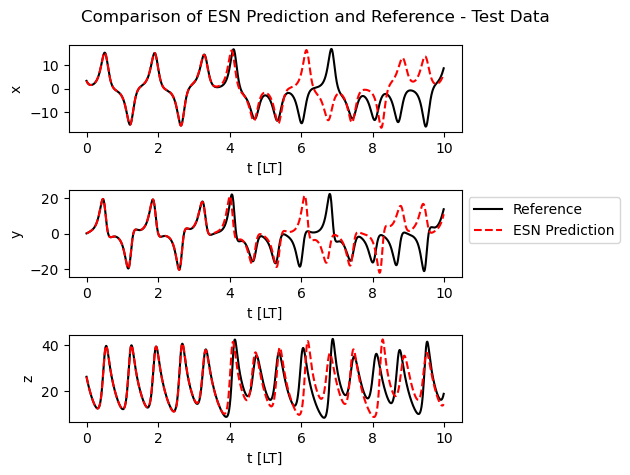

In [6]:
N_plot = 10 * N_lyap
# Define time steps
time_steps = np.arange(0, N_plot * dt, dt) / t_lyap

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1)

# Plot U_test for the first feature
axes[0].plot(time_steps[:N_plot], U_test[:N_plot, 0], color='black', label='Reference')
axes[0].plot(time_steps[:N_plot], prediction[:N_plot, 0], color='red', linestyle='dashed', label='ESN Prediction')
axes[0].set_ylabel("x")
axes[0].set_xlabel("t [LT]")

# Plot U_test for the second feature
axes[1].plot(time_steps, U_test[:N_plot, 1], color='black', label='Reference')
axes[1].plot(time_steps, prediction[:N_plot, 1], color='red', linestyle='dashed', label='ESN Prediction')
axes[1].set_ylabel("y")
axes[1].set_xlabel("t [LT]")
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot prediction and U_test for the third feature
axes[2].plot(time_steps[:N_plot], U_test[:N_plot, 2], color='black', label='Reference')
axes[2].plot(time_steps[:N_plot], prediction[:N_plot, 2], color='red', linestyle='dashed', label='ESN Prediction')
axes[2].set_ylabel("z")
axes[2].set_xlabel("t [LT]")

# Add a title for the entire figure
fig.suptitle("Comparison of ESN Prediction and Reference - Test Data")
# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()